### Ce notebook récupère les données de simulation du modèle depuis "launch_simu_ss.py" pour en faire des visualisations.

In [11]:
from guitare_config import *
from simu_config import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (12,4)

# Simulation

In [2]:
#Lance le calcul de la simulation
import launch_simu_ss

In [3]:
Q = launch_simu_ss.Q
#Mouvement de la corde
QS = Q[:NmS,:]
QB = Q[NmS:,:]

#Passage dans les coordonnées cartésiennes
simuS_NxS_Nt = phiS_Nx_NmS @ QS
simuB_NxNy_Nt = phiB_NxNy_NmB @ QB

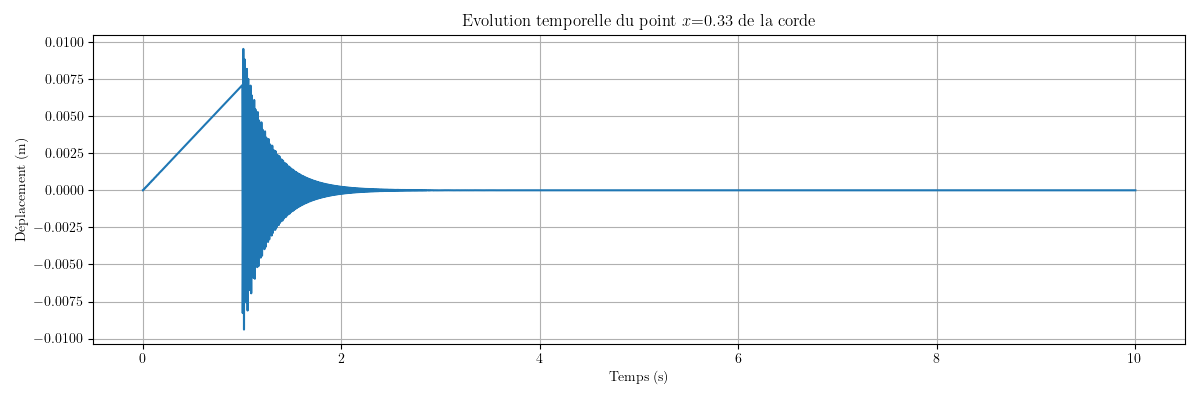

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(t, simuS_NxS_Nt[NxS//2,:],label="")
ax1.grid()
ax1.set_xlabel("Temps (s)")
ax1.set_ylabel("Déplacement (m)")
ax1.set_title(rf"Evolution temporelle du point $x$={xS[NxS//2]:.2f} de la corde")

fig.tight_layout()

plt.show()

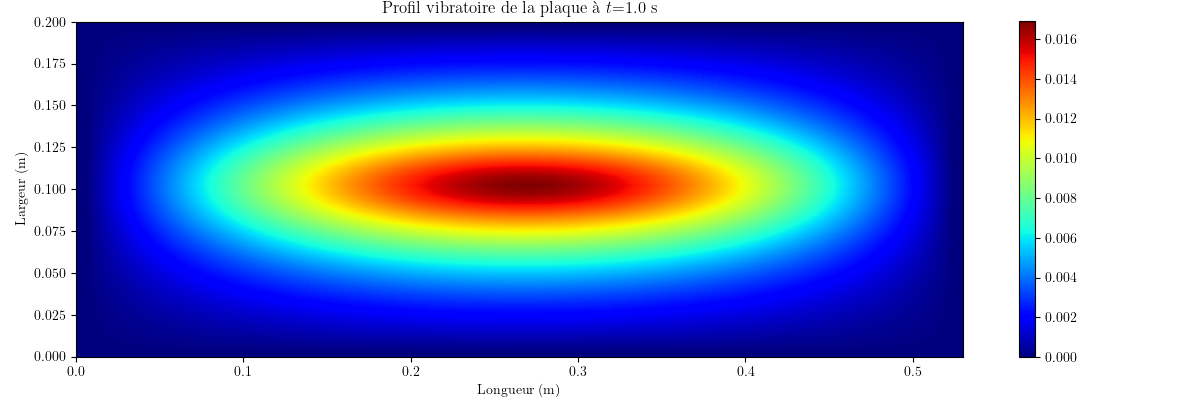

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

img = ax1.imshow(np.abs(simuB_NxNy_Nt[:,1*Fe]).reshape((Nx,Ny)).T,
    extent=[x[0], x[-1] , y[0], y[-1]] ,
    cmap="jet" ,
    interpolation = "bilinear",
    # aspect="auto" ,
    origin="lower")

fig.colorbar(img,ax=ax1)
ax1.set_xlabel("Longueur (m)")
ax1.set_ylabel(r"Largeur (m)")
ax1.set_title(rf"Profil vibratoire de la plaque à $t$={t[1*Fe]:.1f} s")

fig.tight_layout()

plt.show()